# CSE151B Project Milestone Code

## Install the package dependencies before running this notebook

In [857]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset AND  Create a DataLoader class for training

In [858]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
#     f_in = ROOT_PATH + split + "/" + city + "_inputs"
#     inputs = pickle.load(open(f_in, "rb"))
#     inputs = np.asarray(inputs)
    
    outputs = None
    
#     if split=="train":
#         f_out = ROOT_PATH + split + "/" + city + "_outputs"
#         outputs = pickle.load(open(f_out, "rb"))
#         outputs = np.asarray(outputs)

#     return inputs, outputs

    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]

        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.outputs is None:
            data = self.inputs[idx]
        else:
            data = (self.inputs[idx], self.outputs[idx])
        
        if self.transform:
            data = self.transform(data)

        return data

In [859]:
# intialize a dataset on austin just for visualization purpose:
city = 'austin' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [860]:
## Create a DataLoader class for training
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

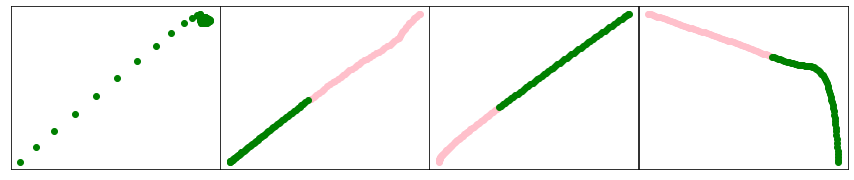

In [861]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], color='pink')
        axs[i].scatter(out[i,:,0], out[i,:,1], color='green')



for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    
    break

# LINEAR Model (4 linear layers for encoder and decoder)

In [862]:
from torch import nn, optim

# class get_output(nn.Module):
#     def forward(self, x):
#         out, _ = x
#         return out
    
class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(

            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16)
        )
        

        self.decoder = nn.Sequential(

            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [863]:
pred = Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

### prepare the dataframe for submission

In [864]:
submission = pd.read_csv('./argo2/sample_submission.csv')
submission = submission.set_index("ID")

In [865]:
submission.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
ID,,,,,,,,,,,,,,,,,,,,,
0_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4_austin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# ONE Model for Each City:

In [871]:
from collections import defaultdict

def def_value():
    return "Not Present"

loss_cities = defaultdict(def_value)
dic = defaultdict(def_value) #key is city, value is [ground truth out list, prediction list]

def train_model_everything(city):
    # intialize a dataset
    train_dataset_city  = ArgoverseDataset(city = city, split = "train")
    
    batch_sz = 64  # batch size 
    train_loader_city = DataLoader(train_dataset_city, batch_size=batch_sz)
    
    loss_lis = []
    for epoch in range(25):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader_city):
            inp, out = sample_batch
            preds_city = pred(inp)
            loss = ((preds_city - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            loss_lis.append(loss.item())

        print('city {} epoch {} training loss: {}'.format(city, epoch, total_loss / len(train_dataset_city)))
        loss_cities[city] = loss_lis
       
    
    #TRAINING PREDICTION FOR ALL:
    dic[city] = [[0], [0]]
    batch_sz = 1  # batch size 
    train_loader_1 = DataLoader(train_dataset_city, batch_size=batch_sz)
    
    for i_batch, sample_batch in enumerate(train_loader_1):
        inp, out = sample_batch
        dic[city][0].append(out)
        dic[city][1].append(pred(inp))
    
    
    
    #VALIDATION
    
    #print validation loss
    val_dataset_city = ArgoverseDataset(city = city, split = 'val')
    
    val_loader_city = DataLoader(val_dataset_city,batch_size=batch_sz)

    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader_city):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()

        val_loss += loss.item()
    print('city {} validation loss: {}'.format(city, val_loss / len(val_dataset_city)))
    
    
    
    #TESTING
    
    #Get the prediction and write to the dataFrame
    test_dataset = ArgoverseDataset(city = city, split = "test")
    batch_sz = 1  # batch size 
    test_loader = DataLoader(test_dataset,batch_size=batch_sz)
    
    preds = []
    test_loss = 0
    for i_batch, sample_batch in enumerate(test_loader):
        inp = sample_batch
        preds.append(pred(inp))
        
    #write to submission dataframe
    for i, p in enumerate(preds):
        new_p = p.reshape(-1, 120).float().tolist()[0]
        submission.loc[str(i)+'_'+city] = new_p
    
    print() #print a new line to separate each city's model

In [872]:
#batch 64
train_model_everything("austin")

city austin epoch 0 training loss: 611944.0190648903
city austin epoch 1 training loss: 500213.43540830695
city austin epoch 2 training loss: 411947.7389614521
city austin epoch 3 training loss: 339712.5663070545
city austin epoch 4 training loss: 280625.92320078507
city austin epoch 5 training loss: 264620.2422899746
city austin epoch 6 training loss: 248481.61117592605
city austin epoch 7 training loss: 222549.8966731855
city austin epoch 8 training loss: 210484.69558367488
city austin epoch 9 training loss: 200691.9958982285
city austin epoch 10 training loss: 169535.27893136794
city austin epoch 11 training loss: 176679.92414291945
city austin epoch 12 training loss: 152476.60931938514
city austin epoch 13 training loss: 147572.5267919232
city austin epoch 14 training loss: 138117.8186249472
city austin epoch 15 training loss: 131911.17487814196
city austin epoch 16 training loss: 134593.76296506636
city austin epoch 17 training loss: 127969.27714069182
city austin epoch 18 trainin

In [ ]:
for city in cities[1:]:
    train_model_everything(city)

city miami epoch 0 training loss: 605618.4808685698
city miami epoch 1 training loss: 445306.8827491301
city miami epoch 2 training loss: 412424.00475421664
city miami epoch 3 training loss: 397260.3383912274
city miami epoch 4 training loss: 367629.2733963405
city miami epoch 5 training loss: 364476.7319516056
city miami epoch 6 training loss: 370163.0332976486
city miami epoch 7 training loss: 347559.38832489896
city miami epoch 8 training loss: 320762.2995130612
city miami epoch 9 training loss: 326273.6025996953
city miami epoch 10 training loss: 373358.2577623034
city miami epoch 11 training loss: 302158.4130144332
city miami epoch 12 training loss: 346957.2172999701
city miami epoch 13 training loss: 347244.5976382789
city miami epoch 14 training loss: 369211.1147753551
city miami epoch 15 training loss: 293347.02756914956
city miami epoch 16 training loss: 297165.8340054441
city miami epoch 17 training loss: 340883.9357790003
city miami epoch 18 training loss: 265681.2907528174


error tracker:

starter code: loss: 243130.4356045948

add one more linear (32, 16): loss: 234230.23708092162 changed to 356302.6224735306 -> 150056.00799303368 (austin)

add one more linear (16, 8): loss: 369038.9848585346

add nn.Dropout() at the end: loss: 139978361.54504338


- 20 epoch and 4 batch: test loss on kaggle 544.36019


city miami validation loss: 98559.84710601612

city pittsburgh validation loss: 25172.430871449083

city dearborn validation loss: 83256.51160414904

city washington-dc validation loss: 59926.98202549418

city palo-alto validation loss: 46965.97407317254

- 20 epoch and 64 batch: test loss on kaggle 1113.73683

city austin validation loss: 279558.9845237329

city miami validation loss: 86737.02004293026

city pittsburgh validation loss: 159859.5950301462

city dearborn validation loss: 64473.38859815645

city washington-dc validation loss: 30957.191266277485

city palo-alto validation loss: 73393.81933790389

- 25 epoch and 3 batch:

city austin validation loss: 52911.8008622041

city miami validation loss: 88357.98424714322


## randomly choose from training set and plot the ground truth and prediction trajectories

In [839]:
from random import *
def plot_truth_prediction(city):
    
    fig, axs = plt.subplots(1,2, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()  
    

    idx = randint(0, int(55029 * 0.8 - 1))
    truth = dic[city][0][idx]
    prediction = dic[city][1][idx]

    truth_array = np.array(truth.tolist()[0])
    prediction_array = np.array(prediction.tolist()[0])


    axs[0].xaxis.set_ticks([])
    axs[0].yaxis.set_ticks([])

    axs[0].scatter(truth_array[:,0], truth_array[:,1], color='green')
    axs[0].set_title(city + ' Ground truth output')

    axs[1].xaxis.set_ticks([])
    axs[1].yaxis.set_ticks([])

    axs[1].scatter(prediction_array[:,0], prediction_array[:,1], color='green')
    axs[1].set_title(city + ' Predicted trajectory')
    

In [800]:
cities

['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto']

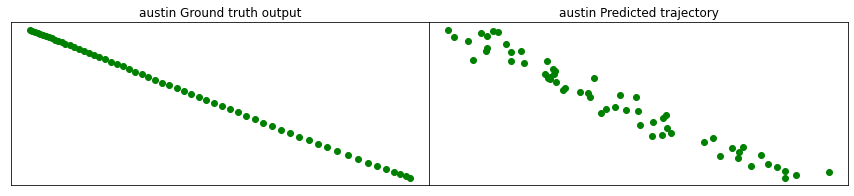

In [798]:
plot_truth_prediction('austin')

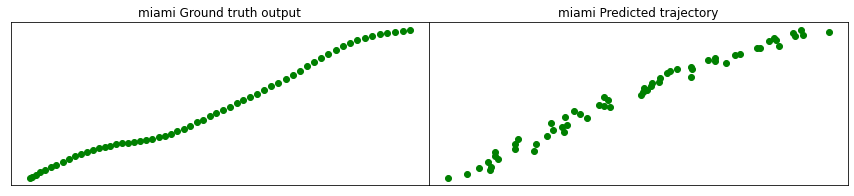

In [809]:
plot_truth_prediction('miami')

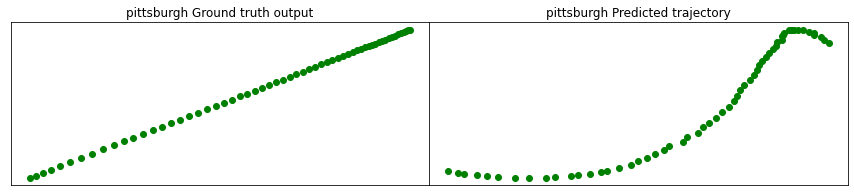

In [833]:
plot_truth_prediction('pittsburgh')

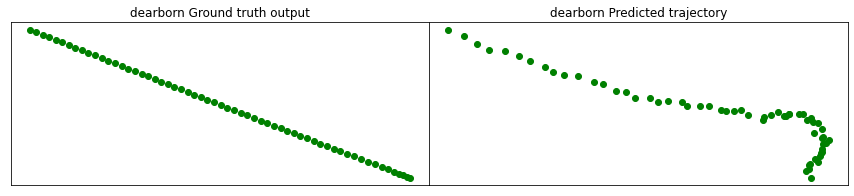

In [834]:
plot_truth_prediction('dearborn')

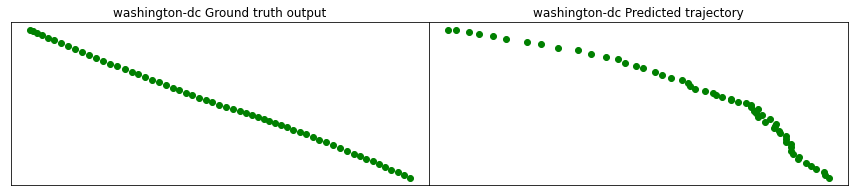

In [851]:
plot_truth_prediction('washington-dc')

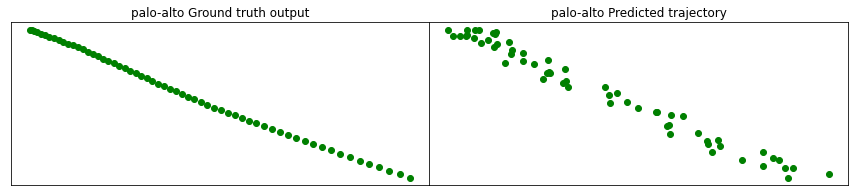

In [855]:
plot_truth_prediction('palo-alto')

## Plot Training Loss over Step for each city

Text(0.5, 1.0, 'Austin Loss')

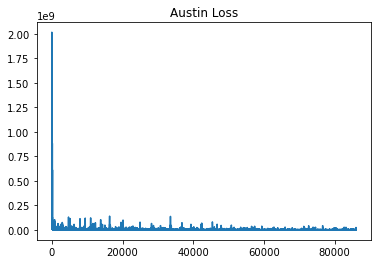

In [741]:
plt.plot(loss_list_cities[0])
plt.title("Austin Loss")

Text(0.5, 1.0, 'Miami Loss')

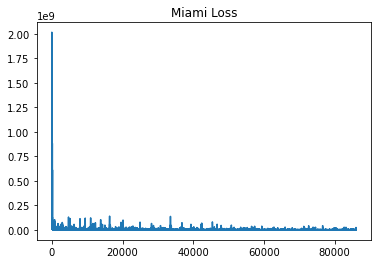

In [691]:
plt.plot(loss_list_cities[1])
plt.title("Miami Loss")

Text(0.5, 1.0, 'Pittsburgh Loss')

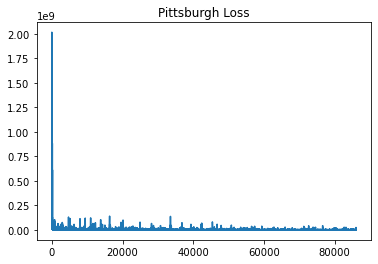

In [692]:
plt.plot(loss_list_cities[2])
plt.title("Pittsburgh Loss")

Text(0.5, 1.0, 'Dearborn Loss')

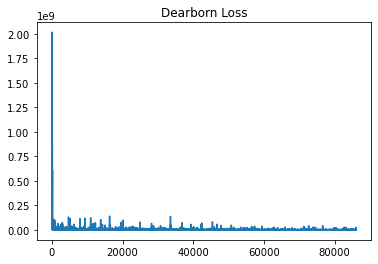

In [694]:
plt.plot(loss_list_cities[3])
plt.title("Dearborn Loss")

Text(0.5, 1.0, 'Washington-dc Loss')

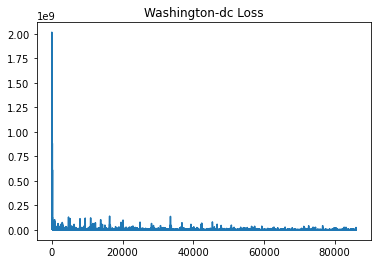

In [695]:
plt.plot(loss_list_cities[4])
plt.title("Washington-dc Loss")

Text(0.5, 1.0, 'Palo-alto Loss')

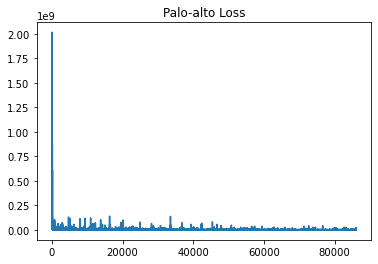

In [696]:
plt.plot(loss_list_cities[5])
plt.title("Palo-alto Loss")

## write predictions on test set to csv file 

In [870]:
from pathlib import Path  
filepath = Path('./argo2/out.csv')  
submission.to_csv(filepath)

old code on writing to submission dataframe and csv file:

In [560]:
### Get the prediction and write to the dataFrame
# def get_pred(city):
#     test_dataset = ArgoverseDataset(city = city, split = "test")
#     batch_sz = 1  # batch size 
#     test_loader = DataLoader(test_dataset,batch_size=batch_sz)
    
#     for i_batch, sample_batch in enumerate(test_loader):
#         inp = sample_batch
        
#     preds = []
#     test_loss = 0
#     for i_batch, sample_batch in enumerate(test_loader):
#         inp = sample_batch
#         preds.append(pred(inp))
        
#     return preds

In [561]:
# submission = pd.read_csv('./argo2/sample_submission.csv')

In [562]:
# submission = submission.set_index("ID")

In [563]:
# cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']

# for city in cities:
#     preds = get_pred(city)
#     for i, p in enumerate(preds):
#         new_p = p.reshape(-1, 120).float().tolist()[0]
#         submission.loc[str(i)+'_'+city] = new_p

In [564]:
# from pathlib import Path  
# filepath = Path('./argo2/out.csv')  
# submission.to_csv(filepath)

# EDA: the distribution of input/output positions for all agents

In [462]:
def get_pivot(city, all_cities=False):
    cities = ['austin', 'dearborn', 'miami', 'palo-alto', 'pittsburgh', 'washington-dc']
    ROOT_PATH = "./argo2/"
    
    all_inputs = []
    all_outputs = []

    def get_data(city):
        f_in = ROOT_PATH + "train/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        for i in inputs.tolist():
            all_inputs.append(i)

        f_out = ROOT_PATH + "train/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        for i in outputs.tolist():
            all_outputs.append(i)
    
    if all_cities == False:
        get_data(city)
    elif all_cities == True:
        for c in cities:
            get_data(c)
        
    #convert to array
    inputs_array = np.asarray(all_inputs)
    outputs_array = np.asarray(all_outputs)

    #reshape so that its one dim for all cities
    n, t, d = inputs_array.shape
    allTimes_inputs_array = inputs_array.reshape(n*t, d)
    n, t, d = outputs_array.shape
    allTimes_outputs_array = outputs_array.reshape(n*t, d)

    #put x and y in groups
    df_input = pd.DataFrame(data=allTimes_inputs_array, columns=['x', 'y'])
    df_input['x_groups'] = df_input.x // 100
    df_input['y_groups'] = df_input.y // 100

    df_output = pd.DataFrame(data=allTimes_outputs_array, columns=['x', 'y'])
    df_output['x_groups'] = df_output.x // 100
    df_output['y_groups'] = df_output.y // 100

    #get the counts for each (x, y) group
    df_input_new = df_input.groupby(['x_groups', 'y_groups']).size()
    df_input_new = pd.DataFrame(df_input_new)

    df_input_new.columns = ['counts']
    df_input_new = df_input_new.reset_index()

    df_output_new = df_output.groupby(['x_groups', 'y_groups']).size()
    df_output_new = pd.DataFrame(df_output_new)
    df_output_new.columns = ['counts']
    df_output_new = df_output_new.reset_index()

    #convert the groups back (*100)
    df_input_new.x_groups = df_input_new.x_groups * 100
    df_input_new.y_groups = df_input_new.y_groups * 100
    df_output_new.x_groups = df_output_new.x_groups * 100
    df_output_new.y_groups = df_output_new.y_groups * 100

    #pivot
    df_input_plot = df_input_new.pivot(index='x_groups', columns='y_groups', values='counts')
    df_output_plot = df_output_new.pivot(index='x_groups', columns='y_groups', values='counts')
    return df_input_plot, df_output_plot
    
def plot_heatmap(city, all_cities=False):
    
    df_input_plot, df_output_plot = get_pivot(city, all_cities)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    fig.subplots_adjust(wspace=.2)
    ax1, ax2 = axes
    
    #heatmap for input & output position
    sns.heatmap(df_input_plot, cmap = "coolwarm", ax = ax1).invert_yaxis()
    ax1.set_title("All input", y=-.3)
    plt.show()
    
    sns.heatmap(df_output_plot, cmap = "coolwarm", ax = ax2).invert_yaxis()
    ax2.set_title("All output ", y=-.3)
    plt.show()



<ipython-input-462-cd185f2a9c81>:78: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-462-cd185f2a9c81>:82: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


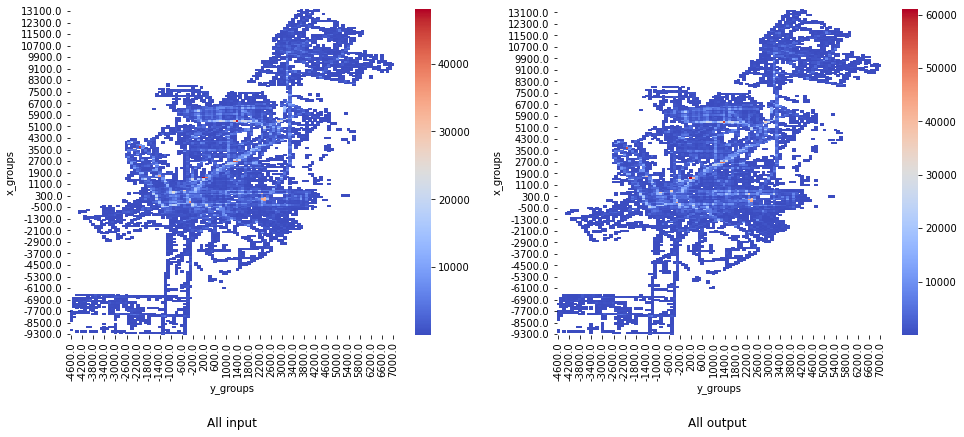

In [463]:
plot_heatmap('washington-dc', True)